In [1]:
# disable eager execution
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

from architectures.fully_connected import AutoEncoder, ResidualAutoEncoderShareWeight, ResidualAutoEncoder
from tensorflow.keras.optimizers.legacy import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.losses import MeanSquaredError

2024-03-30 00:31:35.167473: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-30 00:31:35.388890: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 00:31:35.388945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 00:31:35.419844: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-30 00:31:35.480221: I tensorflow/core/platform/cpu_feature_guar

In [2]:
BINARY_SIZE = 64
PATCH_SIZE = 32
STEPS = 16

In [3]:
network = ResidualAutoEncoder(binary_size=BINARY_SIZE, patch_size=PATCH_SIZE, steps=STEPS)

In [4]:
# pull cifar10 data
from keras.datasets import cifar10
import numpy as np

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [5]:
# bring x_train to -1 to 1
x_train = x_train * 2 - 1
x_test = x_test * 2 - 1

In [6]:
def l2_loss(y_true, y_pred):
    # normalize the loss by the number of pixels
    loss = tf.reduce_mean(tf.square(y_true - y_pred))
    loss = loss / (PATCH_SIZE * PATCH_SIZE * STEPS)
    return loss

In [7]:
network.compile(optimizer=Adam(learning_rate=0.1), loss=l2_loss)

In [8]:
network.fit(x_train, epochs=1, shuffle=True)

Train on 50000 samples


2024-03-30 00:31:43.473285: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-30 00:31:43.599452: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-30 00:31:43.600049: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-30 00:31:43.602459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-30 00:31:43.602880: I external/local_xla/xla/stream_executor

50000/50000 [==============================] - 61s 1ms/sample - loss: 2001850.7989


In [9]:
network.summary()

Model: "residual_auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  2131456   
                                                                 
 encoder_1 (Encoder)         multiple                  2131456   
                                                                 
 encoder_2 (Encoder)         multiple                  2131456   
                                                                 
 encoder_3 (Encoder)         multiple                  2131456   
                                                                 
 encoder_4 (Encoder)         multiple                  2131456   
                                                                 
 encoder_5 (Encoder)         multiple                  2131456   
                                                                 
 encoder_6 (Encoder)         multiple        

In [10]:
network.encoders[0].predict(x_test[0:1])

/home/cezar/micromamba/envs/disertatie/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-03-30 00:32:43.697841: W tensorflow/c/c_api.cc:305] Operation '{name:'residual_auto_encoder/encoder/dense_3/IdentityN' id:95 op device:{requested: '', assigned: ''} def:{{{node residual_auto_encoder/encoder/dense_3/IdentityN}} = IdentityN[T=[DT_FLOAT, DT_FLOAT], _gradient_op_type="CustomGradient-89", _has_manual_control_dependencies=true](residual_auto_encoder/encoder/dense_3/Sign, residual_auto_encoder/encoder/dense_3/MatMul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


array([[-1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,
         1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1.,
        -1., -1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,
         1., -1., -1., -1.,  1.,  1., -1.,  1., -1.,  1., -1., -1., -1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.]],
      dtype=float32)

In [11]:
input_layer = tf.keras.layers.Input(shape=(BINARY_SIZE,))
decoder = tf.keras.models.Model(inputs=input_layer, outputs=network.decoders[0].call(input_layer))
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_64 (Dense)            (None, 512)               33280     
                                                                 
 dense_65 (Dense)            (None, 512)               262656    
                                                                 
 dense_66 (Dense)            (None, 512)               262656    
                                                                 
 dense_67 (Dense)            (None, 3072)              1575936   
                                                                 
 tf_op_layer_Reshape (Tenso  [(None, 32, 32, 3)]       0         
 rFlowOpLayer)                                                   
                                                             

In [12]:
bits = []
for i in range(STEPS):
    input_layer = tf.keras.layers.Input(shape=(PATCH_SIZE, PATCH_SIZE, 3, ))
    encoder = tf.keras.models.Model(inputs=input_layer, outputs=network.encoders[i].call(input_layer))
    res = network.encoders[i].predict(x_test[0:1])
    bits.append(res)
bits = np.array(bits).reshape(-1, BINARY_SIZE)


patches = []
for i in range(STEPS):
    input_layer = tf.keras.layers.Input(shape=(BINARY_SIZE,))
    decoder = tf.keras.models.Model(inputs=input_layer, outputs=network.decoders[i].call(input_layer))
    patches.append(decoder.predict(np.array([bits[i]])))
patches = np.array(patches).reshape(-1, PATCH_SIZE, PATCH_SIZE, 3)

ValueError: ('Error when checking model input: expected no data, but got:', array([[[[ 0.23921573, -0.12156862, -0.6156863 ],
         [ 0.24705887, -0.12941176, -0.6313726 ],
         [ 0.2941177 , -0.09019607, -0.6       ],
         ...,
         [ 0.07450986, -0.25490195, -0.7176471 ],
         [-0.01176471, -0.2862745 , -0.7176471 ],
         [-0.09019607, -0.3333333 , -0.7411765 ]],

        [[ 0.19215691, -0.12156862, -0.6       ],
         [ 0.18431377, -0.1372549 , -0.6862745 ],
         [ 0.24705887, -0.10588235, -0.64705884],
         ...,
         [ 0.06666672, -0.25490195, -0.75686276],
         [-0.01960784, -0.2862745 , -0.7490196 ],
         [-0.06666666, -0.3098039 , -0.73333335]],

        [[ 0.18431377, -0.1372549 , -0.6313726 ],
         [ 0.18431377, -0.14509803, -0.7411765 ],
         [ 0.23921573, -0.12941176, -0.7176471 ],
         ...,
         [ 0.09019613, -0.23137254, -0.73333335],
         [ 0.0196079 , -0.25490195, -0.73333335],
         [-0.05882353, -0.30196077, -0.7411765 ]],

        ...,

        [[-0.46666664, -0.02745098,  0.38823533],
         [-0.67058825, -0.21568626,  0.16078436],
         [-0.75686276, -0.3098039 ,  0.07450986],
         ...,
         [-0.7019608 , -0.23921567,  0.14509809],
         [-0.8980392 , -0.4980392 , -0.15294117],
         [-0.6862745 , -0.3333333 , -0.00392157]],

        [[-0.52156866, -0.09019607,  0.3176471 ],
         [-0.6156863 , -0.19999999,  0.16078436],
         [-0.7254902 , -0.3333333 ,  0.03529418],
         ...,
         [-0.79607844, -0.35686272,  0.0196079 ],
         [-0.77254903, -0.35686272, -0.01176471],
         [-0.84313726, -0.4980392 , -0.1607843 ]],

        [[-0.5764706 , -0.1607843 ,  0.254902  ],
         [-0.56078434, -0.17647058,  0.1686275 ],
         [-0.64705884, -0.30196077,  0.03529418],
         ...,
         [-0.8117647 , -0.3960784 , -0.02745098],
         [-0.73333335, -0.34117645,  0.01176476],
         [-0.8352941 , -0.47450978, -0.1372549 ]]]], dtype=float32))

In [ ]:
patches_copy = patches.copy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

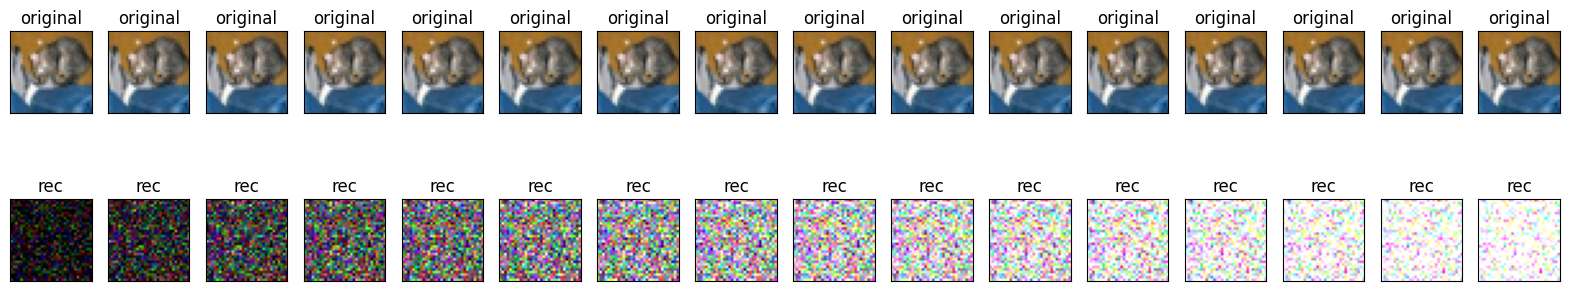

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
reconstructed = np.zeros((PATCH_SIZE, PATCH_SIZE, 3))
x_test = (x_test + 1) / 2
for i in range(STEPS):
    # display original
    ax = plt.subplot(2, STEPS, i + 1)
    plt.imshow(x_test[0])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, STEPS, i + 1 + STEPS)

    # patches_copy[i] = (patches_copy[i] + 1) / 2
    patches_copy[i] = np.clip(patches[i], 0, 1)

    reconstructed = patches_copy[i] + reconstructed
    plt.imshow(reconstructed)
    plt.title("rec")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
x_sample = x_test[:10] 
x_reconstruct = network.predict(x_sample)

x_sample = (x_sample + 1) / 2
x_sample = np.clip(x_sample, 0, 1)

2024-03-29 17:21:51.308701: W tensorflow/c/c_api.cc:305] Operation '{name:'residual_auto_encoder_4/sub' id:2853 op device:{requested: '', assigned: ''} def:{{{node residual_auto_encoder_4/sub}} = Sub[T=DT_FLOAT, _has_manual_control_dependencies=true](residual_auto_encoder_4/decoder_64/Reshape, input_1_5)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


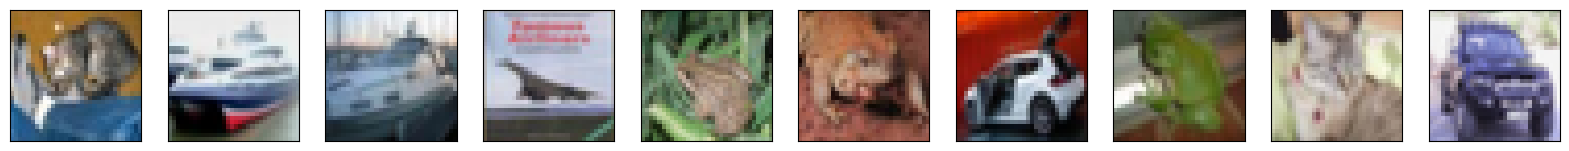

In [ ]:
# plot original images
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    #bring back to 0-1
    
    plt.imshow(x_sample[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

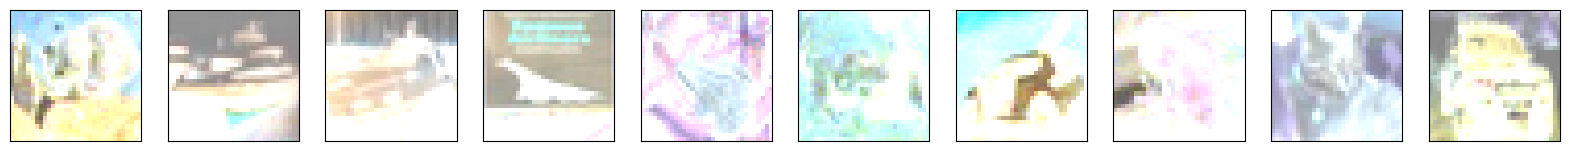

In [ ]:
# bring back to 0-1
x_reconstruct = (x_reconstruct + 1) / 2
x_reconstruct = np.clip(x_reconstruct, 0, 1)

plt.figure(figsize=(20, 4))
# plot reconstructed images
for i in range(n):
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_reconstruct[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
# save x_sample to file
import pickle
with open('x_sample.pkl', 'wb') as f:
    pickle.dump(x_sample, f)

# save x_reconstruct to file
with open('x_reconstruct.pkl', 'wb') as f:
    pickle.dump(x_reconstruct, f)

In [ ]:
import pickle

# load x_sample from file
with open('x_sample.pkl', 'rb') as f:
    x_sample = pickle.load(f)

# load x_reconstruct from file
with open('x_reconstruct.pkl', 'rb') as f:
    x_reconstruct = pickle.load(f)

In [ ]:
import numpy as np
np.moveaxis(x_sample, 0, 0).shape

(10, 32, 32, 3)

In [ ]:
x_sample[1] * 255 - x_reconstruct[1] * 255

array([[[  87.52803   ,   87.51669   ,   87.5253    ],
        [  79.52545   ,   79.51326   ,   79.51524   ],
        [  81.54294   ,   81.51218   ,   81.523026  ],
        ...,
        [  83.53636   ,   83.510086  ,   83.51755   ],
        [  83.54147   ,   83.511734  ,   83.52028   ],
        [  81.540665  ,   81.51056   ,   81.5222    ]],

       [[  93.52878   ,   93.52075   ,   93.53798   ],
        [  87.53836   ,   87.5159    ,   87.53459   ],
        [  87.5491    ,   87.51395   ,   87.54016   ],
        ...,
        [  89.526245  ,   89.51181   ,   89.53804   ],
        [  89.54712   ,   89.509995  ,   89.542725  ],
        [  87.54062   ,   87.51437   ,   87.53073   ]],

       [[  91.54793   ,   91.52353   ,   91.544235  ],
        [  85.58212   ,   85.518936  ,   85.55263   ],
        [  85.57828   ,   85.52002   ,   85.55827   ],
        ...,
        [  87.53075   ,   87.50708   ,   87.54472   ],
        [  87.53528   ,   87.50906   ,   87.5334    ],
        [  85.53111   

In [ ]:
from metrics import psnr_hvs
import torch

PATCH_SIZE=32

# x_sample = x_sample.reshape(-1, 3, PATCH_SIZE, PATCH_SIZE)
x_sample = x_sample.astype('float32')

# x_reconstruct = x_reconstruct.reshape(-1, 3, PATCH_SIZE, PATCH_SIZE)
x_reconstruct = x_reconstruct.astype('float32')

psnr_hvs_val = psnr_hvs.compute_psnr_hvs(x_sample, x_reconstruct)

(10, 32, 32)
X SHAPE ::  (10, 32, 32)
PREV SHAPE ::  (10,)
X SHAPE ::  (10, 32, 32)
PREV SHAPE ::  (10,)


In [ ]:
psnr_hvs_val

array([44.4422381 , 45.64566595, 45.75330889, 48.45575495, 44.8559222 ,
       44.38406544, 44.19486364, 44.18620246, 48.08143264, 45.27361548])

In [ ]:
from imageio import imread
image = imread('poopoo.jpg').astype('float32') / 255.

/tmp/ipykernel_21903/1047406.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread('poopoo.jpg').astype('float32') / 255.


FileNotFoundError: No such file: '/mnt/c/Users/Cezar/Desktop/Disertatie/poopoo.jpg'